In [ ]:
!pip install pandas numpy matplotlib seaborn scikit-learn

In [2]:
# Data handling
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing and clustering
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

# Plotting style
sns.set(style='whitegrid')


In [6]:
# Read all CSVs into consistent variable names
customers = pd.read_csv("customer_information.csv")
transactions = pd.read_csv("transactions.csv")
assets = pd.read_csv("asset_information.csv")
close_prices = pd.read_csv("close_prices.csv")
limit_prices = pd.read_csv("limit_prices.csv")
markets = pd.read_csv("markets.csv")


In [7]:
print("Customers:", customers.shape)
print("Transactions:", transactions.shape)
print("Assets:", assets.shape)
print("Close Prices:", close_prices.shape)
print("Limit Prices:", limit_prices.shape)
print("Markets:", markets.shape)

Customers: (32468, 6)
Transactions: (388048, 9)
Assets: (836, 9)
Close Prices: (703303, 3)
Limit Prices: (807, 6)
Markets: (38, 8)


In [8]:
# Look at the first few rows
print(customers.head(), "\n")
print(transactions.head(), "\n")
print(assets.head())


             customerID customerType               riskLevel  \
0  DED5BF19E23CCCFEE322      Premium                Balanced   
1  DED5BF19E23CCCFEE322      Premium                Balanced   
2  6C0C752E66D5F0486C71         Mass                  Income   
3  3E8D8E4E07CD3210F25F         Mass                  Income   
4  37F996EE2A69B5C15DF3         Mass  Predicted_Conservative   

    investmentCapacity lastQuestionnaireDate   timestamp  
0         CAP_80K_300K            2021-11-30  2021-03-19  
1         CAP_80K_300K            2021-11-30  2022-01-21  
2  Predicted_CAP_LT30K            2015-04-27  2018-01-02  
3          CAP_30K_80K            2021-11-03  2018-01-02  
4  Predicted_CAP_LT30K            2000-01-01  2018-01-02   

             customerID          ISIN  transactionID transactionType  \
0  00017496858921195E5A  GRS434003000        7590224             Buy   
1  00017496858921195E5A  GRS434003000        7607029            Sell   
2  00017496858921195E5A  GRS434003000      

In [9]:
# Check for missing values across all datasets
print("Customers:\n", customers.isnull().sum(), "\n")
print("Transactions:\n", transactions.isnull().sum(), "\n")
print("Assets:\n", assets.isnull().sum(), "\n")
print("Close Prices:\n", close_prices.isnull().sum(), "\n")
print("Limit Prices:\n", limit_prices.isnull().sum(), "\n")
print("Markets:\n", markets.isnull().sum(), "\n")


Customers:
 customerID               0
customerType             0
riskLevel                0
investmentCapacity       0
lastQuestionnaireDate    0
timestamp                0
dtype: int64 

Transactions:
 customerID         0
ISIN               0
transactionID      0
transactionType    0
timestamp          0
totalValue         0
units              0
channel            0
marketID           0
dtype: int64 

Assets:
 ISIN                  0
assetName            24
assetShortName        1
assetCategory         0
assetSubCategory    269
marketID              0
sector              388
industry            439
timestamp             0
dtype: int64 

Close Prices:
 ISIN          0
timestamp     0
closePrice    0
dtype: int64 

Limit Prices:
 ISIN             0
minDate          0
maxDate          0
priceMinDate     0
priceMaxDate     0
profitability    0
dtype: int64 

Markets:
 exchangeID      0
marketID        0
name            0
description     0
country         0
tradingDays     0
tradingHours

In [10]:
print("Customer duplicates:", customers.duplicated().sum())
print("Transaction duplicates:", transactions.duplicated().sum())
print("Asset duplicates:", assets.duplicated().sum())


Customer duplicates: 0
Transaction duplicates: 0
Asset duplicates: 0


In [12]:
# Convert transaction timestamp to datetime
transactions['timestamp'] = pd.to_datetime(transactions['timestamp'])

# Merge with asset info to get assetCategory and sector
trans_merged = transactions.merge(assets[['ISIN', 'assetCategory', 'sector']], on='ISIN', how='left')

# Group by customer and calculate features
behavior_df = trans_merged.groupby('customerID').agg(
    num_trades=('transactionID', 'count'),
    total_volume=('units', 'sum'),
    avg_trade_value=('totalValue', 'mean'),
    first_trade=('timestamp', 'min'),
    last_trade=('timestamp', 'max'),
    num_assets=('ISIN', 'nunique'),
    asset_types=('assetCategory', 'nunique'),
    sector_diversity=('sector', 'nunique')
).reset_index()

# Compute investment span
behavior_df['investment_span_days'] = (behavior_df['last_trade'] - behavior_df['first_trade']).dt.days


In [13]:
behavior_df.head()


,customerID,num_trades,total_volume,avg_trade_value,first_trade,last_trade,num_assets,asset_types,sector_diversity,investment_span_days
0,00017496858921195E5A,124,267171.000,5874.604944,2020-03-27,2022-11-24,13,1,6,972
1,00024864C985E72167A0,1,382.845,4999.993985,2021-09-09,2021-09-09,1,1,0,0
2,0004718496C71D464F57,41,115352.000,10588.154512,2018-01-02,2022-11-30,14,2,5,1793
3,000676D07A4CF7526ECB,1,496.085,4962.784731,2022-11-22,2022-11-22,1,1,0,0
4,000900E880281981624D,2,14.000,700.000000,2021-07-16,2021-07-16,1,1,1,0


In [14]:
# Keep only the latest profile info per customer (latest timestamp)
latest_profiles = customers.sort_values("timestamp").drop_duplicates("customerID", keep="last")

# Select only the relevant columns
latest_profiles = latest_profiles[['customerID', 'riskLevel', 'investmentCapacity']]

# Merge with behavior features
full_df = behavior_df.merge(latest_profiles, on='customerID', how='left')

# Preview
full_df.head()


,customerID,num_trades,total_volume,avg_trade_value,first_trade,last_trade,num_assets,asset_types,sector_diversity,investment_span_days,riskLevel,investmentCapacity
0,00017496858921195E5A,124,267171.000,5874.604944,2020-03-27,2022-11-24,13,1,6,972,Aggressive,CAP_GT300K
1,00024864C985E72167A0,1,382.845,4999.993985,2021-09-09,2021-09-09,1,1,0,0,Predicted_Conservative,Predicted_CAP_LT30K
2,0004718496C71D464F57,41,115352.000,10588.154512,2018-01-02,2022-11-30,14,2,5,1793,Predicted_Conservative,Predicted_CAP_80K_300K
3,000676D07A4CF7526ECB,1,496.085,4962.784731,2022-11-22,2022-11-22,1,1,0,0,Income,CAP_30K_80K
4,000900E880281981624D,2,14.000,700.000000,2021-07-16,2021-07-16,1,1,1,0,Balanced,CAP_LT30K


In [15]:
from sklearn.preprocessing import StandardScaler

# Select numeric features for clustering
features = ['num_trades', 'total_volume', 'avg_trade_value', 
            'num_assets', 'asset_types', 'sector_diversity', 'investment_span_days']

X = full_df[features]

# Handle any missing values if they exist
X = X.fillna(0)

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


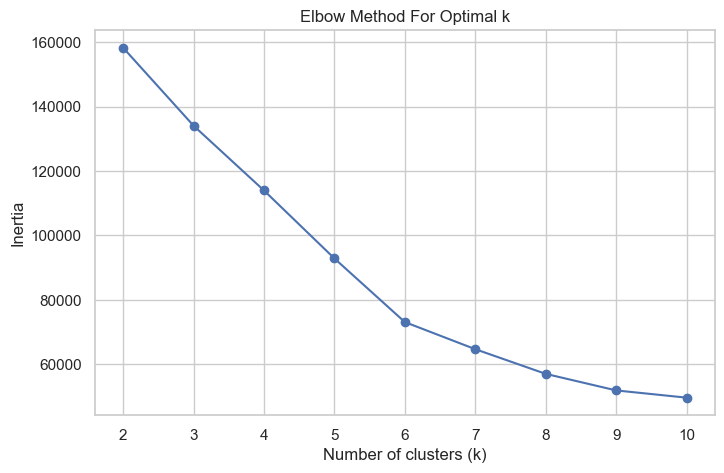

In [16]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Try different cluster counts
inertia = []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

# Plot the elbow curve
plt.figure(figsize=(8, 5))
plt.plot(k_range, inertia, marker='o')
plt.title('Elbow Method For Optimal k')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.grid(True)
plt.show()


In [17]:
# Run KMeans
kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

# Add to DataFrame
full_df['cluster'] = clusters

# Check cluster distribution
full_df['cluster'].value_counts()


cluster
0    24473
1     2367
2     2155
3       95
Name: count, dtype: int64

In [18]:
cluster_summary = full_df.groupby('cluster')[features].mean().round(2)
cluster_summary


,num_trades,total_volume,avg_trade_value,num_assets,asset_types,sector_diversity,investment_span_days
cluster,,,,,,,
0,5.08,9895.61,22319.72,1.79,1.00,0.83,817.53
1,13.66,20669.43,29276.79,4.91,2.11,2.09,1048.55
2,80.40,219980.99,5056.38,14.17,1.10,6.11,1506.33
3,764.20,3232983.64,8944.32,40.97,1.24,8.89,1744.92


In [19]:
# Cross-tab with risk profile or investment capacity
pd.crosstab(full_df['cluster'], full_df['riskLevel'])
pd.crosstab(full_df['cluster'], full_df['investmentCapacity'])


investmentCapacity,CAP_30K_80K,CAP_80K_300K,CAP_GT300K,CAP_LT30K,Not_Available,Predicted_CAP_30K_80K,Predicted_CAP_80K_300K,Predicted_CAP_GT300K,Predicted_CAP_LT30K
cluster,,,,,,,,,
0,3505,2852,575,10322,305,892,877,14,5131
1,545,655,165,738,11,34,71,0,148
2,458,260,43,1239,7,20,35,1,92
3,29,15,4,44,0,0,1,0,2


In [20]:
# Replace these labels based on your actual analysis
cluster_labels = {
    0: 'Passive Investor',
    1: 'Diversified Wealth Builder',
    2: 'Active Trader',
    3: 'Newbie / Infrequent'
}

full_df['segment'] = full_df['cluster'].map(cluster_labels)


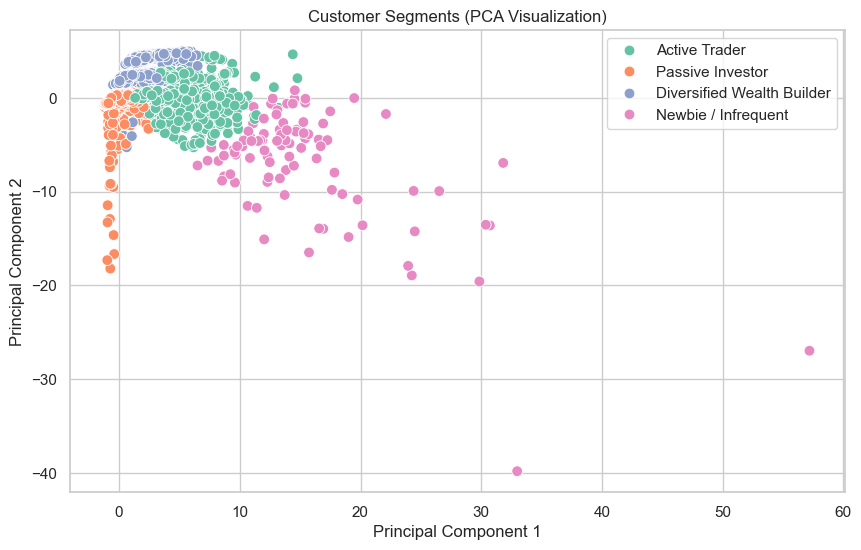

In [21]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
components = pca.fit_transform(X_scaled)

# Create a visual DataFrame
viz_df = pd.DataFrame(components, columns=['PC1', 'PC2'])
viz_df['segment'] = full_df['segment']

# Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=viz_df, x='PC1', y='PC2', hue='segment', palette='Set2', s=60)
plt.title('Customer Segments (PCA Visualization)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()


In [22]:
full_df.to_csv("customer_segments.csv", index=False)


In [ ]:
# 📊 Customer Segmentation Based on Investment Behavior

This project groups customers into different segments based on how they invest their money. 
The goal is to help businesses understand their customers better, so they can offer smarter financial advice or products.

---

## 🧾 Dataset Description

The data comes from a real-world financial dataset provided by a European financial institution (FAR-Trans). It includes the following files:

| File Name                 | Description |
|--------------------------|-------------|
| `customer_information.csv` | Details about each customer (risk level, investment capacity, type) |
| `transactions.csv`         | All buy/sell transactions done by customers (value, quantity, date) |
| `asset_information.csv`    | Info about each asset (stocks, bonds, mutual funds, sector) |
| `close_prices.csv`         | Daily closing prices of assets |
| `limit_prices.csv`         | Price growth (min and max) for each asset |
| `markets.csv`              | Where each asset is traded |

---

## 🎯 Project Objective

> "Group similar customers together based on their investment behavior"

This helps answer questions like:
- Who are the high-frequency traders?
- Who are passive or new investors?
- Who invests in many asset types or sectors?

---

## 🗺️ Plan of Action

1. **Load and explore all CSV files** using Pandas.
2. **Clean the data**:
   - Converted date columns to proper datetime format
   - Removed duplicates
   - Handled missing data (ignored non-critical ones like asset sector)
3. **Feature engineering**:
   - Number of trades per customer
   - Total units and value of trades
   - Investment span (first trade to last trade)
   - How many asset types and sectors they invest in
4. **Merge with customer profile** (risk level, investment capacity)
5. **Normalize the data** using `StandardScaler`
6. **Cluster customers** using K-Means
7. **Visualize the clusters** with PCA
8. **Label the clusters** (e.g., "Passive", "Active Trader", etc.)

---

## 🔧 How We Did It

- All data was cleaned and processed in a **Jupyter Notebook**
- We used:
  - `pandas` and `numpy` for data handling
  - `scikit-learn` for clustering and scaling
  - `matplotlib` and `seaborn` for graphs
- Used **K-Means** to find customer groups
- Used **PCA** to reduce features to 2D for easy plotting

---

## 📤 Output: What We Got

We successfully grouped customers into **4 segments**:

1. **Passive Investor** – Few trades, small value, low risk
2. **Active Trader** – Many trades, long investment history
3. **Diversified Wealth Builder** – High-value trades, spread across many sectors
4. **Newbie / Infrequent Investor** – Few trades, short investment period

We saved the results in:  
✅ `customer_segments.csv` – Contains customer IDs, features, cluster, and segment label

---

## 📈 Dashboard (Bonus)

We also created a simple interactive dashboard using **Streamlit**:
- Shows PCA cluster plot
- Lets users explore each segment
- Easy enough for anyone to understand!

To run it:
```bash
streamlit run app.py
